# EDA 

In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# display multiple outputs, default is 'last_expr' (last expression)
# http://ipython.readthedocs.io/en/stable/config/options/terminal.html
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sqlalchemy as sa
import psycopg2 as pg
import seaborn as sns

from psycopg2.extras import execute_values

from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

### Pull down all features

In [2]:
query = '''
    SELECT *
    FROM prod.features
    WHERE "Season Type" = 'NCAA Tourney' and
        holdout_s1 = 0 and
        holdout_s2 = 0
'''

conn = pg.connect(database='postgres',
                  user='postgres',
                  password='w207final',
                  host='35.185.225.167')

df = pd.read_sql_query(query, conn)

In [3]:
df.dtypes.value_counts()
df.describe().T

float64    18
int64      11
object      2
dtype: int64

,count,mean,std,min,25%,50%,75%,max
Season,1426.0,2.008050e+03,3.176268,2003.000000,2005.000000,2008.000000,2011.000000,2013.000000
DayNum,1426.0,1.390996e+02,4.218910,134.000000,136.000000,137.000000,139.000000,154.000000
Team,1426.0,1.293577e+03,104.185887,1102.000000,1210.000000,1281.000000,1393.000000,1462.000000
Opponent,1426.0,1.293577e+03,104.185887,1102.000000,1210.000000,1281.000000,1393.000000,1462.000000
Outcome,1426.0,5.000000e-01,0.500175,0.000000,0.000000,0.500000,1.000000,1.000000
Score,1426.0,6.894741e+01,12.066513,29.000000,61.000000,69.000000,77.000000,121.000000
OpponentScore,1426.0,6.894741e+01,12.066513,29.000000,61.000000,69.000000,77.000000,121.000000
NumOT,1426.0,7.433380e-02,0.311331,0.000000,0.000000,0.000000,0.000000,2.000000
holdout_s1,1426.0,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
holdout_s2,1426.0,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


See correlation matrix between various features and target

In [4]:
target = ['Outcome']
features = ['AvgRank', 'OpponentAvgRank', 'TwoPointPct_Team', 'ThreePointPct_Team',
            'FreeThrowPct_Team', 'OffensiveRebounds_Team', 'DefensiveRebounds_Team',
            'WinPct', 'OpponentWinPct', 'WinPctDiff', 'SeedDiff',
            'AvgPointsFor', 'AvgPointsAgainst', 'AvgNetPointsFor'
           ]

In [5]:
cm = df[target+features].corr()
cm

,Outcome,AvgRank,OpponentAvgRank,TwoPointPct_Team,ThreePointPct_Team,FreeThrowPct_Team,OffensiveRebounds_Team,DefensiveRebounds_Team,WinPct,OpponentWinPct,WinPctDiff,SeedDiff,AvgPointsFor,AvgPointsAgainst,AvgNetPointsFor
Outcome,1.000000,-0.327037,0.327037,0.125174,0.045726,0.025110,0.140307,0.113723,0.263281,-0.263281,0.369306,-0.505541,0.185305,-0.097735,0.318327
AvgRank,-0.327037,1.000000,0.045002,-0.370529,-0.213295,-0.102174,-0.175693,-0.236979,-0.637091,0.041499,-0.475932,0.618817,-0.389069,0.247336,-0.710886
OpponentAvgRank,0.327037,0.045002,1.000000,-0.028539,0.016440,-0.030776,0.066925,0.066905,0.041499,-0.637091,0.475932,-0.618817,0.046954,0.003155,0.052482
TwoPointPct_Team,0.125174,-0.370529,-0.028539,1.000000,0.264201,0.048309,-0.260515,0.103969,0.433617,0.048239,0.270286,-0.204278,0.362481,-0.055322,0.485574
ThreePointPct_Team,0.045726,-0.213295,0.016440,0.264201,1.000000,0.289423,-0.253479,0.043932,0.261041,-0.002049,0.184519,-0.146685,0.377621,0.115214,0.331411
FreeThrowPct_Team,0.025110,-0.102174,-0.030776,0.048309,0.289423,1.000000,-0.275225,-0.102866,0.094208,0.033904,0.042294,-0.021777,0.152974,0.097185,0.083275
OffensiveRebounds_Team,0.140307,-0.175693,0.066925,-0.260515,-0.253479,-0.275225,1.000000,0.350356,0.148777,-0.042155,0.133911,-0.212520,0.457770,0.319582,0.220173
DefensiveRebounds_Team,0.113723,-0.236979,0.066905,0.103969,0.043932,-0.102866,0.350356,1.000000,0.263854,-0.069017,0.233460,-0.248628,0.460666,0.171441,0.373117
WinPct,0.263281,-0.637091,0.041499,0.433617,0.261041,0.094208,0.148777,0.263854,1.000000,-0.016473,0.712907,-0.464410,0.442502,-0.301238,0.828634
OpponentWinPct,-0.263281,0.041499,-0.637091,0.048239,-0.002049,0.033904,-0.042155,-0.069017,-0.016473,1.000000,-0.712907,0.464410,-0.018066,-0.003154,-0.018235


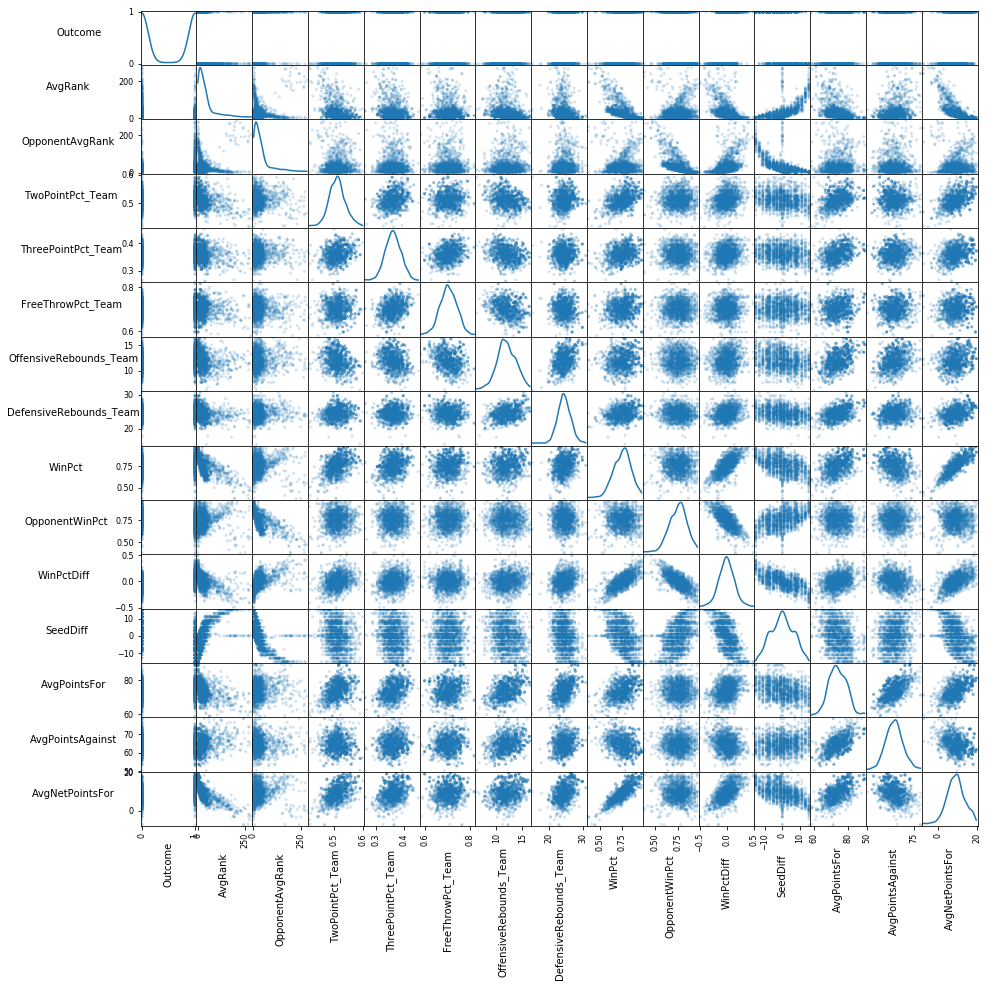

In [6]:
axs = pd.plotting.scatter_matrix(df[target+features], alpha=0.2, figsize=(15, 15), diagonal='kde')
n = len(df[target+features].columns)
for x in range(n):
    for y in range(n):
        # to get the axis of subplots
        ax = axs[x, y]
        # to make x axis name vertical  
        ax.xaxis.label.set_rotation(90)
        # to make y axis name horizontal 
        ax.yaxis.label.set_rotation(0)
        # to make sure y axis names are outside the plot area
        ax.yaxis.labelpad = 50

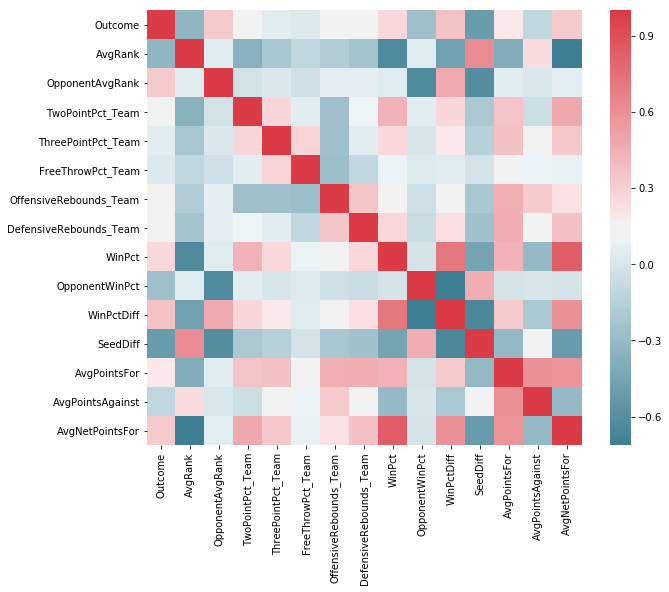

In [7]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(cm, mask=np.zeros_like(cm, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)